In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

Print top 5 rows

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [93]:
def plot_timeseries(df):
    plt.figure(figsize=(15,9))
    plt.plot(df)
    # plt.ylabel(df.columns[0], fontsize=20)
    plt.show()

Plot the timeseries from above

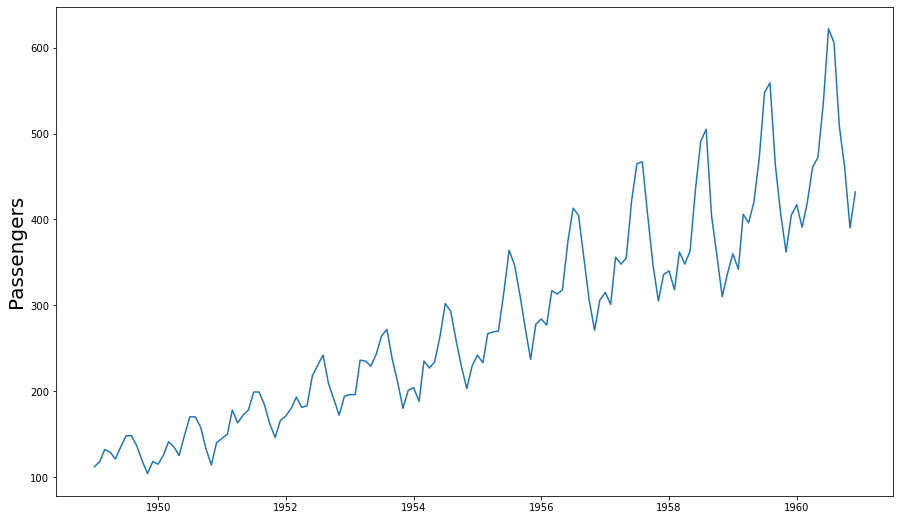

In [13]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [14]:
df.shape

(144, 1)

In [17]:
rolling_mean = df.rolling(window=6).mean()
rolling_std = df.rolling(window=6).std()

Plot two timeseries:
- with rolling mean 
- with rolling std

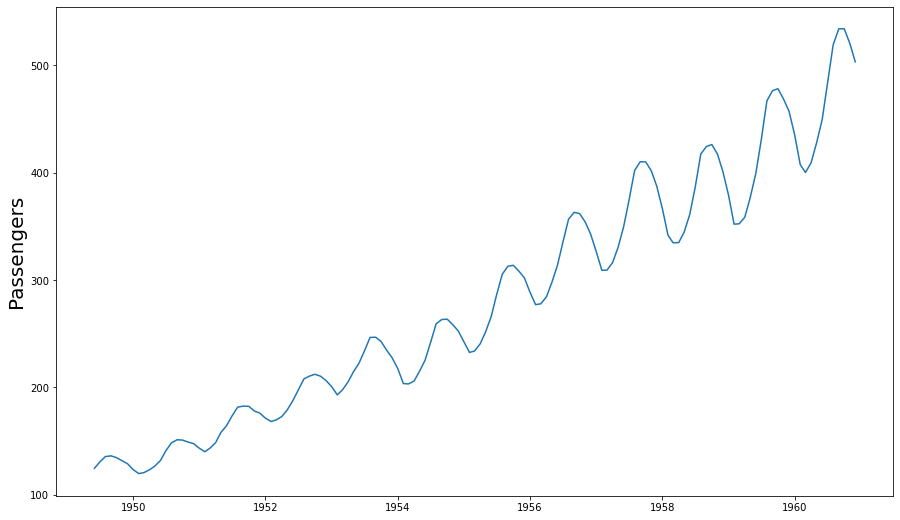

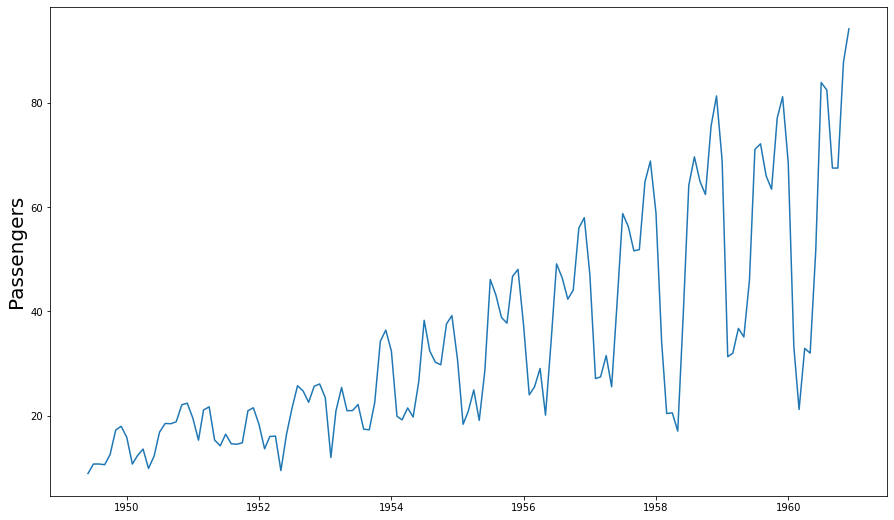

In [19]:
plot_timeseries(rolling_mean)
plot_timeseries(rolling_std)

Test the stationarity of all timeseries

In [26]:
adfuller(df)

(0.8153688792060502,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [23]:
adfuller(rolling_mean.fillna(method="bfill"))

(1.2331942361766624,
 0.9962073883562144,
 8,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 536.2004827657935)

In [24]:
adfuller(rolling_std.fillna(method="bfill"))

(0.9335169970266926,
 0.9935125075481115,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 729.8745595884384)

> None of these are even close to stationary

Transform the original timeseries with logarithm

In [30]:
df_log = np.log(df)

Plot transformed timeseries

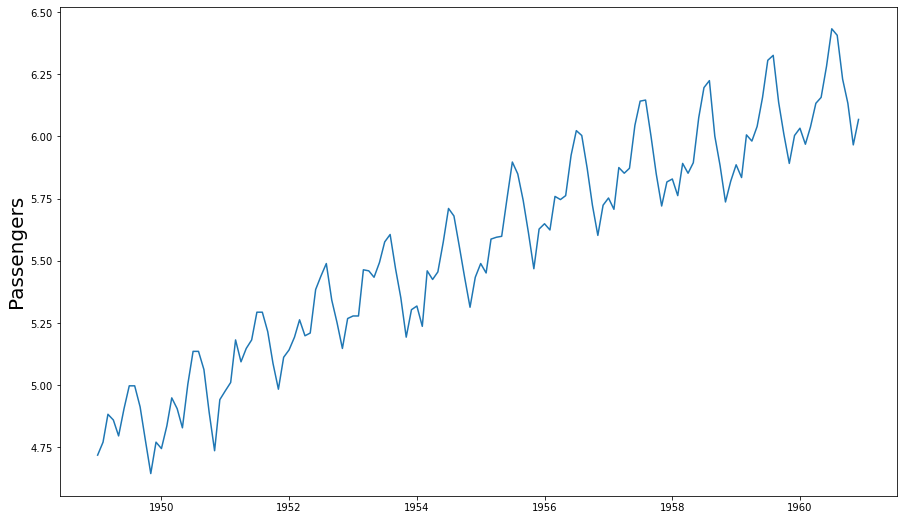

In [31]:
plot_timeseries(df_log)

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [32]:
adfuller(df_log)

(-1.7170170891069612,
 0.4223667747703909,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -445.3990312497209)

> closer but still not stationary

In [48]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


2
            Passengers
Month                 
1949-01-01         0.0
1949-02-01         0.0
1949-03-01         8.0
1949-04-01       -17.0
1949-05-01        -5.0
(-16.561184774589325, 1.90659219271111e-29, 11, 132, {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}, 1002.1066054410932)


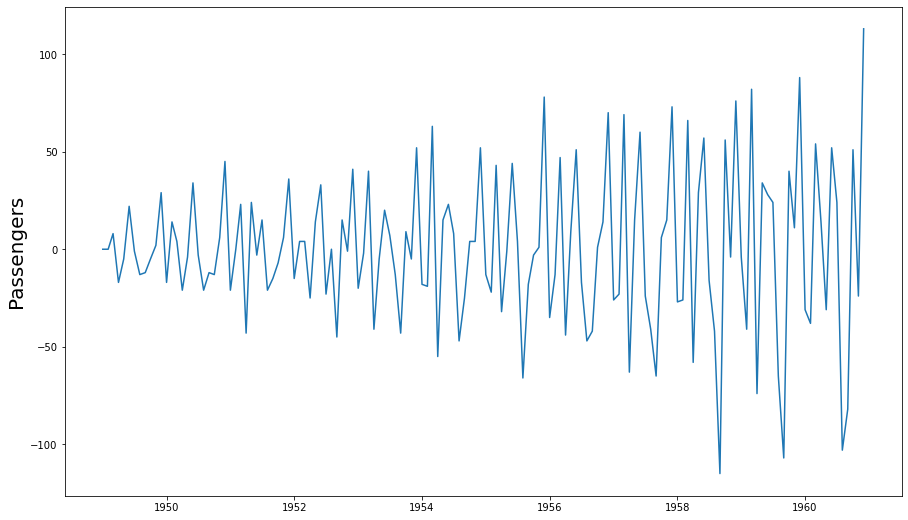

In [49]:
shifted_df = df.copy()
count = 0

while adfuller(shifted_df)[0] > adfuller(shifted_df)[4]["5%"]:
    shifted_df = shifted_df - shifted_df.shift()
    shifted_df.fillna(method="bfill", inplace=True)
    count += 1
    
print(count)
print(shifted_df.head())
print(adfuller(shifted_df))
plot_timeseries(shifted_df)

Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

In [50]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

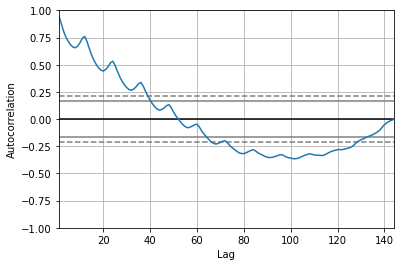

In [52]:
autocorrelation_plot(df)

p = 40
d = 2

Plot the predictions (not transformed to the original scale)

In [91]:
X = df.values
split = int(len(X) * .66)
train, test = X[:split], X[split:]
history = [x for x in train]
predictions = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(8,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"prediction: {yhat}, expected: {obs}") 

prediction: [277.76270061], expected: [306]
prediction: [340.12365269], expected: [315]
prediction: [295.68467776], expected: [301]
prediction: [291.63710359], expected: [356]
prediction: [377.268368], expected: [348]
prediction: [341.50006957], expected: [355]
prediction: [369.43910415], expected: [422]
prediction: [430.63817878], expected: [465]
prediction: [487.05200746], expected: [467]
prediction: [488.07444295], expected: [404]
prediction: [377.7559374], expected: [347]
prediction: [319.35462], expected: [305]
prediction: [309.08541827], expected: [336]
prediction: [377.91553948], expected: [340]
prediction: [310.97953198], expected: [318]
prediction: [308.20247737], expected: [362]
prediction: [373.91172245], expected: [348]
prediction: [344.50537507], expected: [363]
prediction: [377.98731337], expected: [435]
prediction: [445.32710187], expected: [491]
prediction: [520.04825695], expected: [505]
prediction: [521.71750544], expected: [404]
prediction: [351.85988845], expected: 

In [87]:
from sklearn.metrics import mean_squared_error

In [92]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse

48.27161327951808

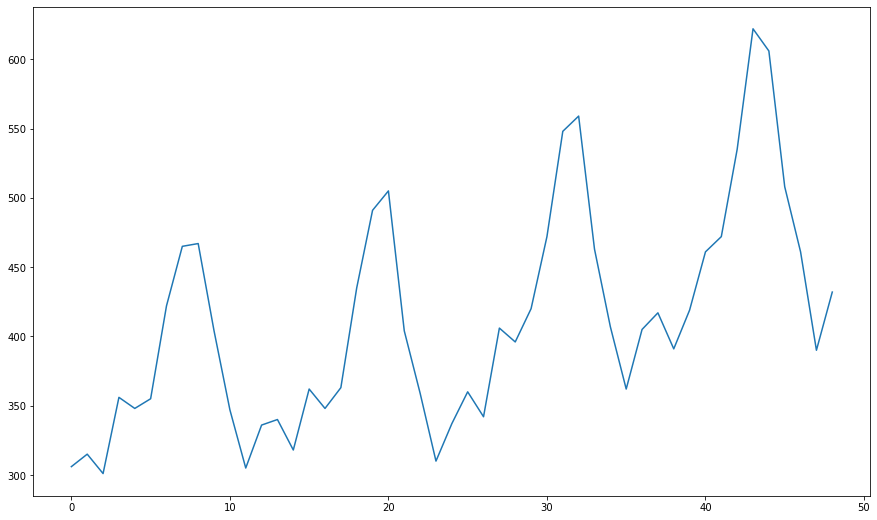

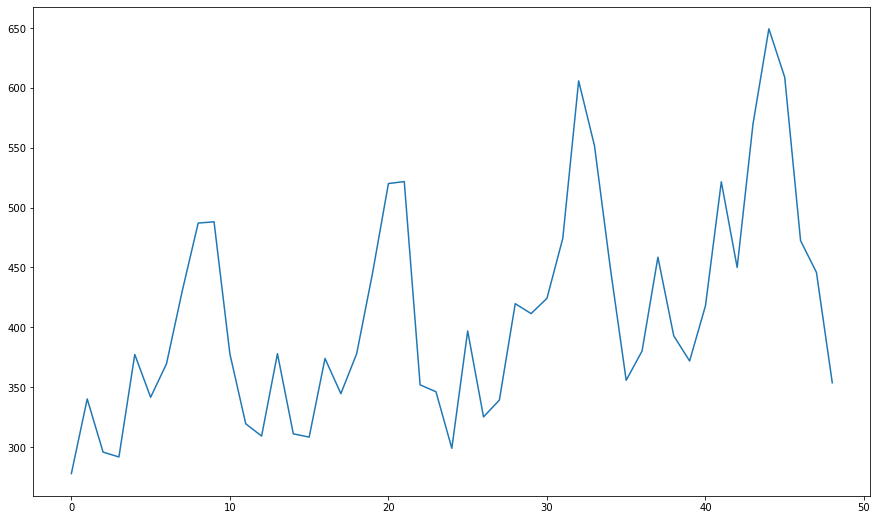

In [95]:
plot_timeseries(test)
plot_timeseries(predictions)

Plot the predictions (transformed to the original scale)

Plot the predictions for the next 10 years